In [5]:
# import some additional tools
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization, Activation, Dense, Dropout
from keras.utils import np_utils                         # NumPy related tools
from keras.models import Sequential  # Model type to be used
import tensorflow_datasets as tfds

In [6]:
# Reload the MNIST data
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
ds = tfds.load('cifar100', with_info=False, shuffle_files=True, try_gcs = True, data_dir='gs://hien7613storage2/datasets', download=False)


In [7]:

batch_size = 1024

def train_preprocessing(x):
  data = x['image']
  data = tf.keras.layers.Rescaling(1./255)(data)
# data = tf.keras.layers.Normalization()(data)
  # data = tf.keras.layers.Resizing(image_size, image_size)(data)
  # data = tf.keras.layers.RandomFlip("horizontal")(data)
  # data = tf.keras.layers.RandomRotation(factor=0.02)(data)
  # data = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)(data)
  label = tf.one_hot(x['label'],100)
  return (data, label, x['label'])
  
train_ds = (
    ds['train']
    .shuffle(batch_size * 2)
    .map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE).cache()
)
test_ds = (
    ds['test']
    .shuffle(batch_size * 2)
    .map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE).cache()
)

In [8]:
# TPU config
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.57.6.34:8470']


In [9]:
# with tf.device('/device:GPU:0'):
with tpu_strategy.scope():

  model = Sequential()                                 # Linear stacking of layers

  # Convolution Layer 1
  model.add(Conv2D(32, (3, 3))) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  convLayer01 = Activation('relu')                     # activation
  model.add(convLayer01)

  # Convolution Layer 2
  model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  model.add(Activation('relu'))                        # activation
  convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
  model.add(convLayer02)

  # Convolution Layer 3
  model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  convLayer03 = Activation('relu')                     # activation
  model.add(convLayer03)

  # Convolution Layer 4
  model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  model.add(Activation('relu'))                        # activation
  convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
  model.add(convLayer04)
  model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

  # Fully Connected Layer 5
  model.add(Dense(512))                                # 512 FCN nodes
  model.add(BatchNormalization())                      # normalization
  model.add(Activation('relu'))                        # activation

  # Fully Connected Layer 6                       
  model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
  model.add(Dense(100))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.summary()

In [22]:
with tpu_strategy.scope():

  vgg_model = tf.keras.applications.VGG19(
      include_top=False,
      weights="imagenet",
      input_shape=(32,32,3),
  )

  model = tf.keras.Sequential()
  model.add(vgg_model)
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(100, activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # model.summary()

In [10]:
from keras import regularizers

with tpu_strategy.scope():

    model = Sequential()
    weight_decay = 0.005

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(100))
    #modification to return pre-softmax logits!
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Lion(learning_rate=0.0001), metrics=['accuracy'])


In [4]:
# !pip install tf-nightly

In [11]:
history = model.fit(train_ds, steps_per_epoch=50000//batch_size, epochs=100, verbose=1, 
                    validation_data=test_ds, validation_steps=10000//batch_size)

InvalidArgumentError: ignored

In [39]:
score = model.evaluate(test_ds)
print('Test score:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 2s 23ms/step - loss: 135.2618 - accuracy: 0.5455
Test score: 135.26177978515625
Test accuracy: 0.5454643964767456


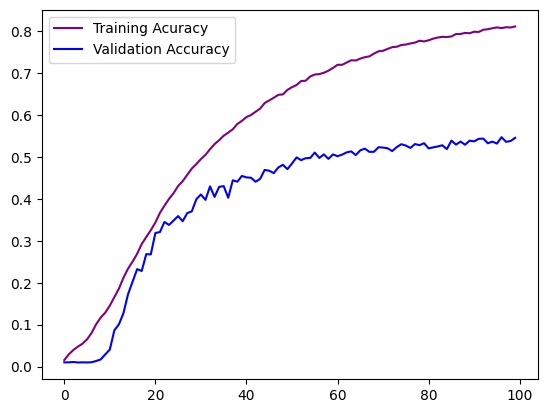

In [40]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

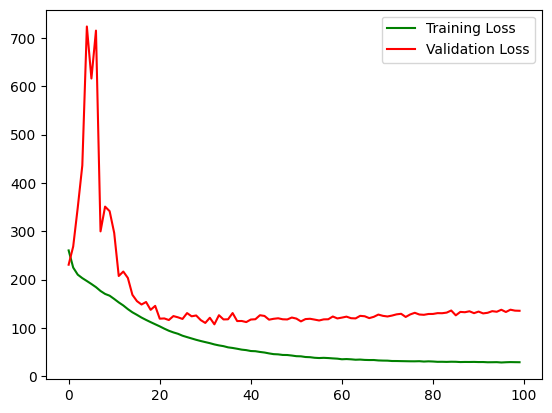

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

## Great results! 

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [ ]:
from keras import backend as K

# choose any image to want by specifying the index
img = X_test[3]
img = np.expand_dims(img, axis=0) # Keras requires the image to be in 4D, so we add an extra dimension to it.

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
    
    _convout1_f = K.function(inputs, [layer.output])
    
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')


In [ ]:
plt.figure()
plt.imshow(X_test[3].reshape(28,28), cmap='gray', interpolation='none')

In [ ]:
visualize(convLayer01) # visualize first set of feature maps

In [ ]:
visualize(convLayer02) # visualize second set of feature maps

In [ ]:
visualize(convLayer03)# visualize third set of feature maps

In [ ]:
visualize(convLayer04)# visualize fourth set of feature maps

#### For a 3D visualization of a very similar network, visit http://scs.ryerson.ca/~aharley/vis/conv/